# Data set

Until this point we have prepared all the data for the models:
- 1: MODIS sandwiches
- 2: CDL calibrated and rescaled 
- 3: NASS %

Now we want to build a way to feed the network with the correct . 


For example one file will contain:

**(MODIS_county_X_year_Y,    
CDL_county_X_year_Y,   
NASS%_county_x_year_Y )**

The files will be saved in the folder "DataSet" with the name structure:

**County.Year.pt** 

Using torch.save() to save the files in *.pt* format. Alowing having the data ready as torch vectors for feeding the network. 

In [1]:
countryKey="US_South_spatial" #model info in pylib

startyear=2008
endyear=2021

#libraries 

import torch
import torchvision 
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
import numpy as np 
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage import io
import numpy as np
import numpy as np
import time
import sys, os, imp
import glob
from osgeo import gdal
from PIL import Image
import matplotlib.pyplot as plt
dirname = os.path.dirname("fieldcrop-detection-south")
filename = os.path.join(dirname, 'pyLib')
sys.path.append(filename)
from modis_lib import modisDataConverter as dataConv #main library of fuctions
imp.reload(dataConv)
from modis_lib import anas_functions as aCDL #main library of CDL preprossesing fuctions
imp.reload(aCDL)

from modis_lib import modelDictionary as modelDictionary
imp.reload(modelDictionary)
modelInfo=modelDictionary.getModelData()[countryKey]

C:\Users\Alex\anaconda3\envs\tf2.4gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Alex\AppData\Local\Temp\ipykernel_20944\533770471.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import sys, os, imp


hyyywertuuu  ttttteeettt
hyyywertuuu  ttttteeettt
helo
helo


In [2]:
#Modis folders
#stacked_Files ="Preprocessing/modis/DataStacked"
stacked_Files_torch="Preprocessing/modis/modis_TorchPoints" #modis_TorchPoints
######CDL folders:
data_reshaped_torch = "Preprocessing/CDL/CDL_reshaped_torch"#folder to saved data reshaped in torch format

#Info comming from diccionary 
shapefiles=modelInfo["shapefilesAB"] #routes of shape files
countryCode=modelInfo["countryCode"]

statistics="statistics/STATS_US_ALL_WHEAT_2000_2021_fixed.csv" #folder with the NASS statistics

stats = dataConv.getLabelsFromCSV(statistics, shapefiles ,
                          startyear,endyear, minPercentage=0,
                          printNotFound=False)


Train_target = aCDL.getFilesFromLabels_data_points(stats, stacked_Files_torch, 
                                                data_reshaped_torch, countryCode)


allShapes: 241
241 shapes
18185 csvtuples
Labels: 2633


**Train_target** contains a triple list with the staked data, CDL data and NASS data. 
Each index of the thre lists correspond to a county in a specific year.

In [3]:

Train_target

(['Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2021.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2020.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2019.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2018.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2017.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2016.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2015.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2014.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2013.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2012.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2011.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2010.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2009.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torc

In [4]:
len(Train_target[0])

2633

In [5]:
len(Train_target[0]) == len(Train_target[1]) == len(Train_target[2])

True

Now we look at the umber of unique counties IDs. 

Beacuse in this aproche we will split some counties for Training and some for Testing. 

In [11]:
counties = []

for i in range(len(Train_target[0])):
    if Train_target[0][i].split(".")[3] in counties: #position 3 hast the countie id
        continue
    else:
        counties.append(Train_target[0][i].split(".")[3])

In [12]:
counties[:5] #list with unique counties

['US241', 'US243', 'US245', 'US246', 'US250']

This leve us:

In [13]:
#80% train A
#20%testing B
print("All counties:", len(counties))
print("80% counties A:", len(counties)*.8)
print("20% counties B:", len(counties)*.2)

All counties: 236
80% counties A: 188.8
20% counties B: 47.2


In [14]:
#data points
#80% train A
#20%testing B
print("80% data points A:", len(Train_target[0])*.8)
print("20% data points B:", len(Train_target[0])*.2)

80% data points A: 2106.4
20% data points B: 526.6


Now we select randomly 189 counties to make group A:

In [15]:
import random
random.seed(117)
counties_A = random.sample(counties, 189)
print(counties_A) #counties for group A

['US938', 'US923', 'US919', 'US930', 'US979', 'US2706', 'US917', 'US2178', 'US981', 'US2591', 'US907', 'US2609', 'US2163', 'US2186', 'US961', 'US966', 'US1819', 'US2686', 'US2568', 'US278', 'US909', 'US972', 'US988', 'US894', 'US918', 'US2703', 'US975', 'US2565', 'US985', 'US983', 'US243', 'US2752', 'US2602', 'US2717', 'US2564', 'US2777', 'US2209', 'US2624', 'US2561', 'US913', 'US2147', 'US2617', 'US2172', 'US990', 'US976', 'US936', 'US921', 'US964', 'US905', 'US2658', 'US897', 'US2549', 'US2613', 'US262', 'US888', 'US2770', 'US962', 'US2705', 'US2749', 'US2714', 'US943', 'US960', 'US955', 'US973', 'US2750', 'US2734', 'US939', 'US914', 'US971', 'US2679', 'US945', 'US950', 'US2171', 'US2603', 'US2636', 'US2136', 'US2582', 'US246', 'US2584', 'US2630', 'US887', 'US987', 'US924', 'US889', 'US2535', 'US2170', 'US1802', 'US2199', 'US949', 'US2158', 'US2168', 'US2629', 'US273', 'US906', 'US952', 'US929', 'US974', 'US2691', 'US2575', 'US2204', 'US946', 'US963', 'US2543', 'US927', 'US2538', 'US

And the rest go to group B:

In [16]:
counties_B = []
for i in counties:
    if i in counties_A:
        continue 
    else:
        counties_B.append(i)
print(counties_B) #counties for group B

['US245', 'US896', 'US898', 'US900', 'US901', 'US904', 'US910', 'US915', 'US916', 'US920', 'US934', 'US937', 'US942', 'US947', 'US968', 'US970', 'US977', 'US984', 'US986', 'US989', 'US2142', 'US2154', 'US2156', 'US2159', 'US2162', 'US2164', 'US2176', 'US2193', 'US2194', 'US2205', 'US2532', 'US2556', 'US2566', 'US2570', 'US2574', 'US2589', 'US2632', 'US2645', 'US2661', 'US2667', 'US2674', 'US2682', 'US2694', 'US2723', 'US2735', 'US2743', 'US2745']


Now with the desicion of wich counties are asign to wich groups. We procced to find the corresponding files for those counties:

In [17]:
def AB_lits(Train_target, A, B):
    """
    Looks for the correct ID in a list of files 
    and returns the list of files corrsponding 
    to A and B groups
    """
    Train_target_A = [[], [], []]
    Train_target_B = [[], [], []]

    for i in range(len(Train_target[0])):
        splits = Train_target[0][i].split(".")
        
        if splits[3] in A:
            Train_target_A[0].append(Train_target[0][i])
            Train_target_A[1].append(Train_target[1][i])
            Train_target_A[2].append(Train_target[2][i])
        elif splits[3] in B:
            Train_target_B[0].append(Train_target[0][i])
            Train_target_B[1].append(Train_target[1][i])
            Train_target_B[2].append(Train_target[2][i])
            
    return Train_target_A, Train_target_B

In [18]:
A_files, B_files = AB_lits(Train_target, counties_A, counties_B)

List A_files contain the files for group A, and same logic for B_files.

In [196]:
len(A_files[0])

2121

In [197]:
len(B_files[2])

512

In [198]:
2121/(2121+512)

0.8055450056969237

In [199]:
512/(2121+512)

0.19445499430307633

In [200]:
type(A_files[2][0])

float

In [218]:
#B_files

Lets save this lists in a file to avoid all this calling of data in the traning code.

In [32]:
def read_lits(l0,l1,l2):
    """recives 3 files with lists
    return a triple list with the lists"""
    
    # empty list to read list from a file
    b0 = []
    b1 = []
    b2 = []
    # open file and read the content in a list
    with open(l0, 'r') as fp:
        for line in fp:
            # remove linebreak from a current name
            # linebreak is the last character of each line
            x = line[:-1]
            # add current item to the list
            b0.append(x)

    with open(l1, 'r') as fp:
        for line in fp:
            x = line[:-1]
            b1.append(x)

    with open(l2, 'r') as fp:
        for line in fp:
            x = line[:-1]
            b2.append(float(x))
    B2 = [b0, b1, b2]
    return B2



In [288]:
B2 = read_lits('lists_data/list_B_0.txt', 'lists_data/list_B_1.txt', 'lists_data/list_B_2.txt')

In [291]:
len(B2[0])

512

In [292]:
A_files == A2

True

In [293]:
B_files == B2

True

# Temporal Split

In [4]:
Train_target

(['Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2021.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2020.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2019.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2018.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2017.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2016.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2015.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2014.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2013.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2012.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2011.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2010.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2009.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torc

In [17]:
t = Train_target[1][78].split(".")[2]
int(t) >= 2013

False

In [21]:
A_temp = [[],[],[]]
B_temp = [[],[],[]]

for i in range(len(Train_target[0])):
    if int(Train_target[1][i].split(".")[2]) >= 2019:
        B_temp[0].append(Train_target[0][i])
        B_temp[1].append(Train_target[1][i])
        B_temp[2].append(Train_target[2][i])
    else:
        A_temp[0].append(Train_target[0][i])
        A_temp[1].append(Train_target[1][i])
        A_temp[2].append(Train_target[2][i])

In [24]:
len(A_temp[0])

2086

In [25]:
len(B_temp[0])

547

In [26]:
2086 + 547

2633

In [27]:
len(Train_target[0])

2633

In [28]:
A_temp

[['Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2018.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2017.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2016.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2015.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2014.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2013.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2012.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2011.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2010.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2009.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2008.US241.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2018.US243.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2017.US243.pt',
  'Preprocessing/modis/modis_TorchPoints/MODIS_torc

Saving the lists in txt files:

In [36]:

with open("lists_data/A_temp_0.txt", "w") as fp:
    for item in A_temp[0]:
        # write each item on a new line
        fp.write("%s\n" % item)
    
with open("lists_data/A_temp_1.txt", "w") as fp:
    for item in A_temp[1]:
        fp.write("%s\n" % item)    
    
with open("lists_data/A_temp_2.txt", "w") as fp:
    for item in A_temp[2]:    
        fp.write("%s\n" % item)    
        
#######################

with open("lists_data/B_temp_0.txt", "w") as fp:
    for item in B_temp[0]:    
        fp.write("%s\n" % item)  
        
        
with open("lists_data/B_temp_1.txt", "w") as fp:
    for item in B_temp[1]:    
        fp.write("%s\n" % item)  
        
with open("lists_data/B_temp_2.txt", "w") as fp:
    for item in B_temp[2]:    
        fp.write("%s\n" % item)  

In [37]:
Bb2 = read_lits('lists_data/B_temp_0.txt', 'lists_data/B_temp_1.txt', 'lists_data/B_temp_2.txt')

In [39]:
len(Bb2[1])

547

Now lets learn how to use a sequencer to read little by little files. To feed the network.

[nice explaniation pytorch and tesorflow](https://towardsdatascience.com/a-tale-of-two-frameworks-985fa7fcec)

torch.Size([1, 544, 993])
(1, 544, 993)
(544, 993)


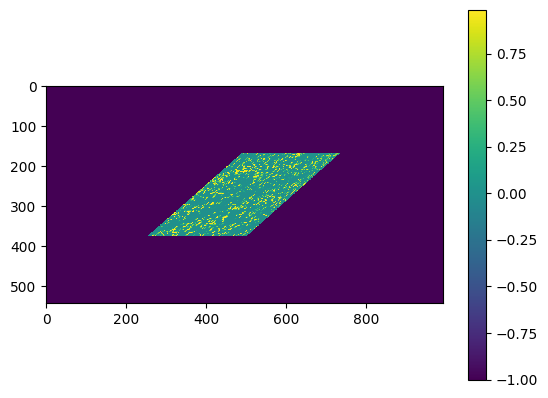

In [125]:
target_file = "Preprocessing/CDL/CDL_reshaped_torch/resh.CDLr.2019.US.US963.pt"
#true target
target = torch.load(target_file)
print(target.shape)
target = target.numpy()
print(target.shape)
target = target[0, :, :]
print(target.shape)
plt.imshow(target, interpolation='nearest')
plt.colorbar()
plt.show()

In [4]:
#prediction
import torch
test_file = 'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2008.US963.pt'
x = torch.load(test_file).float()
x = x[None, :]
print(f'x shape {x.shape}')
test = model(x)
test = test.detach().numpy()
print(test.shape)
test = test[0, 0, :, :]
print(test.shape)
plt.imshow(test)
plt.colorbar()
plt.show()

x shape torch.Size([1, 1, 23, 544, 993])


NameError: name 'model' is not defined

## Take a quick look at the data

In [42]:
import numpy as np

In [6]:
import torch
a = torch.load('Preprocessing/CDL/CDL_reshaped_torch/resh.CDLr.2008.US.US912.pt')
print(a)
na = a.numpy()
na = na[0, :, :]
na.shape

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]], dtype=torch.float64)


(544, 993)

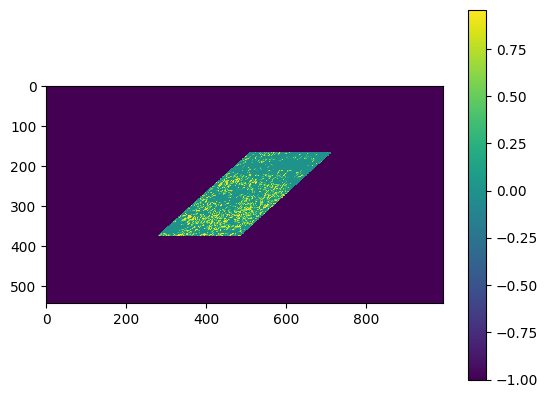

In [7]:
from matplotlib import pyplot as plt
plt.imshow(na, interpolation='nearest')
plt.colorbar()
plt.show()

(1, 23, 544, 993)
(544, 993)


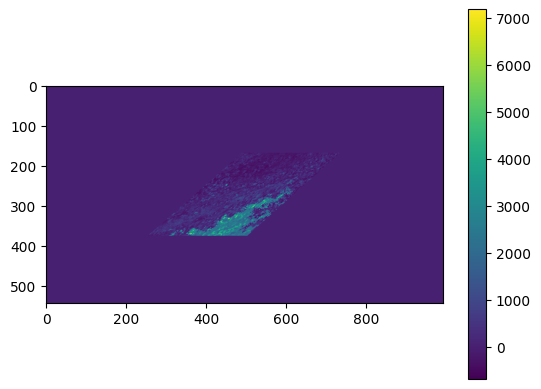

In [131]:
#mod = 'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2008.US912.pt'
mod = 'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2008.US963.pt'
a = torch.load(mod)
#print(a)
na = a.numpy()
print(na.shape)
na = na[0, 0, :, :]
print(na.shape)
plt.imshow(na)
plt.colorbar()
plt.show()

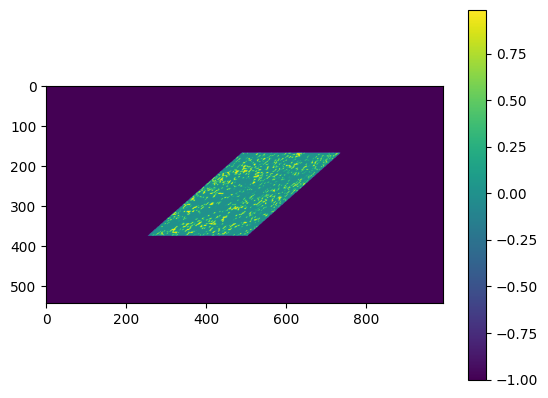

In [71]:
plt.imshow(target)
plt.colorbar()
plt.show()

In [72]:
target.shape

(544, 993)

In [73]:
tranfer = np.zeros((544,993))
tranfer.shape

(544, 993)

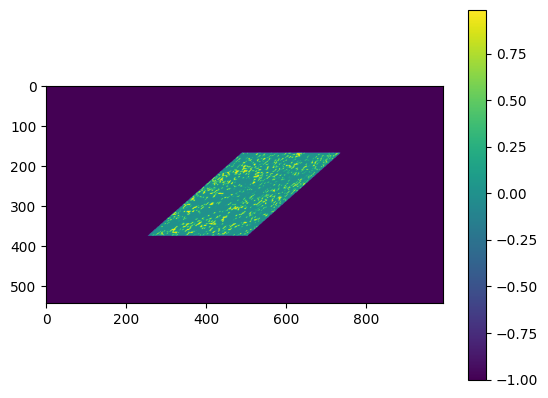

In [76]:
plt.imshow(tranfer)
plt.colorbar()
plt.show()

In [75]:
r = np.copyto(tranfer, target, where=-1)
type

type

In [83]:
x = torch.randn(5, 5)
y = torch.ones(5, 5)

In [84]:
x

tensor([[-0.4119,  1.6985,  0.5317,  1.8062,  1.4265],
        [ 0.6487,  1.6945,  0.4574,  0.1883,  0.7313],
        [-0.6536, -0.7139,  0.2246, -2.0554, -0.3887],
        [-0.5612, -0.3233,  0.8611, -0.5575, -0.8386],
        [ 0.3072, -0.0683,  1.5684, -2.0838, -0.9730]])

In [85]:
y

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [86]:
torch.where(x > 0, x, y)

tensor([[1.0000, 1.6985, 0.5317, 1.8062, 1.4265],
        [0.6487, 1.6945, 0.4574, 0.1883, 0.7313],
        [1.0000, 1.0000, 0.2246, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.8611, 1.0000, 1.0000],
        [0.3072, 1.0000, 1.5684, 1.0000, 1.0000]])

In [106]:
test_file = 'Preprocessing/modis/modis_TorchPoints/MODIS_torch.US.A2008.US963.pt'
test = model(torch.load(test_file).float())
test = test[0,0,:,:] #prediction from model
#test

(544, 993)


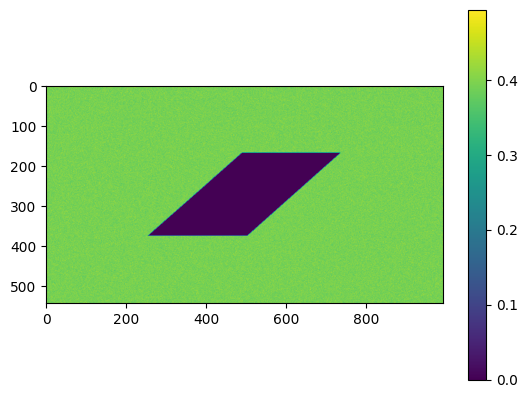

In [111]:
na = test.detach().numpy()
print(na.shape)

plt.imshow(na)
plt.colorbar()
plt.show()

In [104]:
target = torch.load('Preprocessing/CDL/CDL_reshaped_torch/resh.CDLr.2008.US.US912.pt')
target = target[0,:,:]
#target

(544, 993)


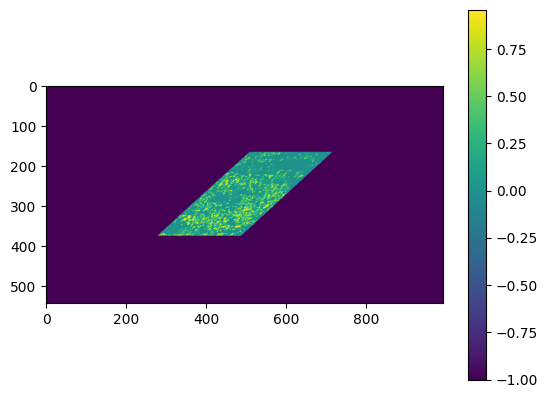

In [112]:
na = target.numpy()
print(na.shape)

plt.imshow(na)
plt.colorbar()
plt.show()

In [108]:
mask = torch.where(target == -1, target, test)

In [109]:
mask

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]], dtype=torch.float64,
       grad_fn=<WhereBackward0>)

(544, 993)


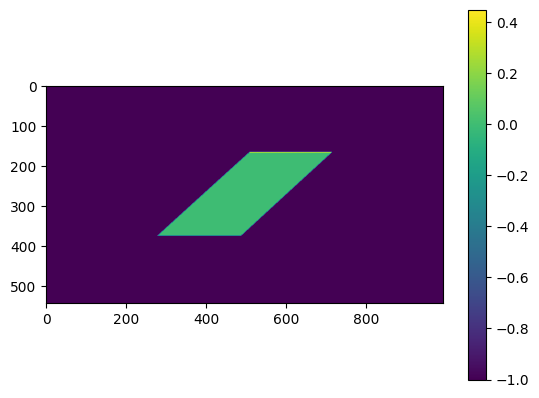

In [114]:
na = mask.detach().numpy() 
print(na.shape)

plt.imshow(na)
plt.colorbar()
plt.show()

(544, 993)


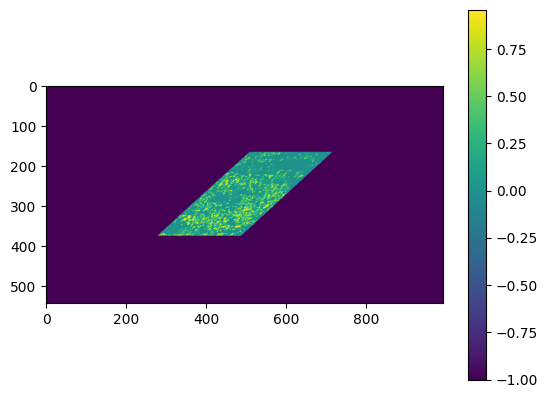

In [119]:
na = target.numpy()
print(na.shape)

plt.imshow(na)
plt.colorbar()
plt.show()

(544, 993)


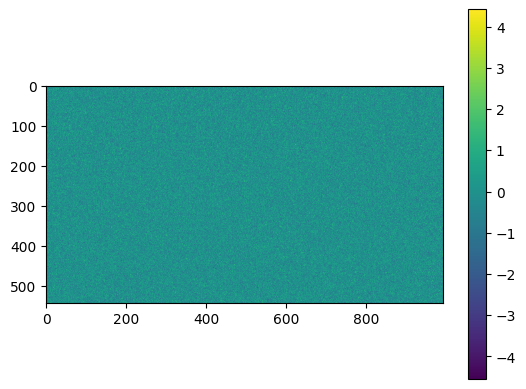

In [116]:
x = torch.randn(544, 993)
na = x.numpy() 
print(na.shape)

plt.imshow(na)
plt.colorbar()
plt.show()

In [117]:
mask2 = torch.where(target == -1, target, x) #transfer pixels from target to x 

(544, 993)


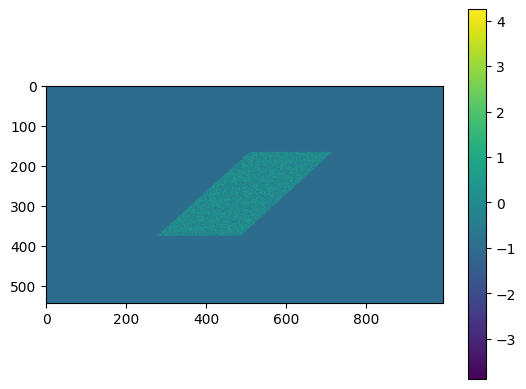

In [118]:
na = mask2.numpy() 
print(na.shape)

plt.imshow(na)
plt.colorbar()
plt.show()